In [218]:
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from IPython.display import clear_output
from PIL import Image

def get_image(img):
    import io
    buffer = io.BytesIO()
    getattr(img, "savefig")(buffer, format='jpeg', quality=90)
    return Image.open(buffer)

In [219]:
class Particule():
    def __init__(self, swarm, position, fit_fn):
        self.swarm = swarm
        self.position = position
        self.best_position = position
        self.speed = np.zeros_like(position)
        self.w = .6
        self.c1 = 2
        self.c2 = 2
        self.fit_fn = fit_fn
    
    def update_pos(self):
        best_nb_position = self.get_neighbours_best_position()
        self.speed = self.w * self.speed + \
            self.c1 * np.random.rand() * (self.best_position - self.position) + \
            self.c2 * np.random.rand() * (best_nb_position - self.position) 
        self.position += self.speed
        
        if(self.value > self.best_value):
            self.best_position = self.position
    
    @property
    def value(self):
        return self.fit_fn(self.position)    
    
    @property
    def best_value(self):
        return self.fit_fn(self.best_position)
    
    def get_neighbours_best_position(self):
        return max([*self.get_neighbours(), self], key=lambda p: p.best_value).best_position
        
    def get_neighbours(self):
        """This should give only neighbours"""
        raise NotImplementedError()
    
    def __repr__(self):
        return "Particule at " + np.array2string(self.position, precision=3) + \
                  " - Value: " + np.array2string(self.value, precision=3)
    
    
class PredefinedNeighboursParticule(Particule):
    def __init__(self, swarm, position, fit_fn, neighbours_index):
        super().__init__(swarm, position, fit_fn)
        self.neighbours_index = neighbours_index
    
    def get_neighbours(self):
        return [self.swarm[i] for i in self.neighbours_index]
    

class KClosestL2NeighboursParticule(Particule):
    def __init__(self, swarm, position, fit_fn, nb_neighbours):
        super().__init__(swarm, position, fit_fn)
        self.nb_neighbours = nb_neighbours
    
    def get_neighbours(self):
        distances = [np.linalg.norm(p.position-self.position) for p in self.swarm]
        indices = np.argsort(distances)[1:self.nb_neighbours+1]
        return [self.swarm[i] for i in indices]

class KClosestCosNeighboursParticule(Particule):
    def __init__(self, swarm, position, fit_fn, nb_neighbours):
        super().__init__(swarm, position, fit_fn)
        self.nb_neighbours = nb_neighbours
    
    def get_neighbours(self):
        distances = [ np.dot(p.position, self.position) / (np.linalg.norm(p.position) * np.linalg.norm(self.position)) for p in self.swarm]
        indices = np.argsort(distances)[1:self.nb_neighbours+1]
        return [self.swarm[i] for i in indices]

In [220]:
# Define fitness function

def fn_sq(x):
    return np.sum(.5-x**2, axis=-1)

def fn_o4(x):
    return np.sum(.5 + 10 * x ** 2 - np.array([1,.5]) * x**4, axis=-1)

def fn_sin(x):
    return np.sum(np.sin(x), axis=-1)

def fn_sq_cos(x):
    return np.sum(15*np.cos(2*x) - x**2, axis=-1)


fn = fn_sq_cos

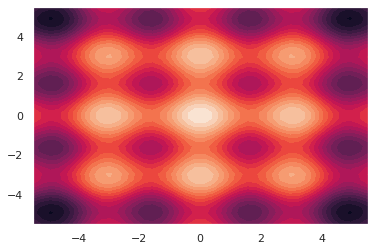

In [221]:
dim_pos = 2
min_pos = -np.ones(dim_pos)*5.5
max_pos = np.ones(dim_pos)*5.5


# Plot fitness (if 2d)

X = np.stack(np.meshgrid(*np.linspace(min_pos.tolist(), max_pos.tolist(), 40).T), axis=-1)
Y = fn(X)
ax = plt.contourf(X[..., 0], X[...,1], Y, levels=25)

In [248]:
# Define Swarm

nb_particules = 100
nb_neighbours = 5

swarm = []
for i in range(nb_particules):
    init_pos = np.random.rand((dim_pos))*(max_pos - min_pos) + min_pos
    
#     neighbours = [(i+j) % nb_particules for j in range(1, nb_neighbours + 1)]
#     swarm.append(PredefinedNeighboursParticule(swarm, init_pos, fn, neighbours))

    swarm.append(KClosestL2NeighboursParticule(swarm, init_pos, fn, 3))

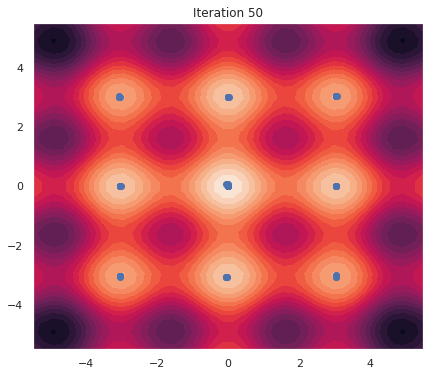

In [249]:
# Main loop

nb_loop = 50
plot = True

if plot:
    figs=[]
    fig, ax = plt.subplots(1, figsize=(7, 6))
    
for i in range(nb_loop):
    for p in swarm:
        p.update_pos()
        
    # Make plot
    if plot:
        ax.cla()
        
        X = np.stack(np.meshgrid(*np.linspace(min_pos.tolist(), max_pos.tolist(), 40).T), axis=-1)
        Y = fn(X)
        plt.contourf(X[..., 0], X[...,1], Y, levels=25)
        
        a_plot = ax.scatter(*list(zip(*[p.position for p in swarm])))
        ax.set_xlim((min_pos[0], max_pos[0]))
        ax.set_ylim((min_pos[1], max_pos[1]))
        ax.set_title("Iteration %d" % (i+1))
        figs += [get_image(fig)]
        display(fig)
        clear_output(wait=True)
        
if plot:
    figs[0].save("optim.gif", "gif", save_all=True, append_images=figs[1:], duration=200, loop=0)

In [237]:
for p in swarm:
    print(p)

Particule at [3.065 0.06 ] - Value: 20.319
Particule at [3.086 3.091] - Value: 10.754
Particule at [-3.046 -0.01 ] - Value: 20.446
Particule at [2.877 3.005] - Value: 10.087
Particule at [ 0.002 -0.016] - Value: 29.992
Particule at [ 0.152 -3.488] - Value: 13.655
Particule at [-3.029  3.019] - Value: 10.884
Particule at [-3.058  3.026] - Value: 10.884
Particule at [ 3.073 -0.017] - Value: 20.406
Particule at [ 0.001 -0.002] - Value: 30.
Particule at [ 0.017 -3.073] - Value: 20.408
Particule at [ 0.006 -3.048] - Value: 20.446
Particule at [0.028 0.014] - Value: 29.97
Particule at [ 0.025 -0.02 ] - Value: 29.968
Particule at [3.055 3.045] - Value: 10.891
Particule at [ 3.157 -0.008] - Value: 20.025
Particule at [3.03  3.039] - Value: 10.897
Particule at [-2.964 -0.008] - Value: 20.277
Particule at [-3.001 -3.031] - Value: 10.851
Particule at [-3.032 -6.082] - Value: -17.741
Particule at [ 3.04  -0.082] - Value: 20.239
Particule at [ 3.125 -3.128] - Value: 10.438
Particule at [-3.    -2.9